In [1]:
# !pip install -U git+https://github.com/openfisca/openfisca-ceq.git@master#egg=OpenFisca-CEQ
# !pip install -U git+https://github.com/openfisca/openfisca-senegal.git@ceq#egg=OpenFisca-Senegal
# !pip install -U git+https://github.com/openfisca/openfisca-mali.git@master#egg=OpenFisca-Mali
# !pip install -U git+https://github.com/openfisca/openfisca-cote-d-ivoire.git@master#egg=OpenFisca-COTE-D-IVOIRE

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline
import pandas as pd
from openfisca_ceq.tools.survey_scenario import build_ceq_survey_scenario
from openfisca_ceq.tools.indirect_taxation.tax_benefit_system_indirect_taxation_completion import (
    indirect_tax_by_country,
)
from openfisca_ceq.tools.data import year_by_country
from openfisca_ceq.tools.data_ceq_correspondence import (
    ceq_input_by_harmonized_variable,
    ceq_intermediate_by_harmonized_variable,
    non_ceq_input_by_harmonized_variable,
)

# Build country scenario

## Country selection

In [3]:
country = "mali"

In [4]:
# Parameters
country = "senegal"

In [5]:
year = year_by_country[country]
survey_scenario = build_ceq_survey_scenario(legislation_country=country, year=year)

# Aggegates check

## Income variables

### Disagregated income variables

In [6]:
ceq_by_harmonized_variable = dict()
ceq_by_harmonized_variable.update(ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable.update(ceq_intermediate_by_harmonized_variable)
ceq_by_harmonized_variable.update(non_ceq_input_by_harmonized_variable)
ceq_by_harmonized_variable["autres_revenus_du_capital_brut"] = (
    "autres_revenus_du_capital_brut"
)
ceq_by_harmonized_variable["pension_retraite_brut"] = "pension_retraite_brut"
ceq_by_harmonized_variable["revenu_foncier_brut"] = "revenu_foncier_brut"
ceq_by_harmonized_variable["revenu_non_salarie_brut"] = "revenu_non_salarie_brut"
ceq_by_harmonized_variable["salaire_brut"] = "salaire_brut"
ceq_by_harmonized_variable["salaire_super_brut"] = "salaire_super_brut"
ceq_by_harmonized_variable

{'rev_i_autoconsommation': 'autoconsumption',
 'rev_i_autres': 'other_income',
 'rev_i_autres_transferts': 'gifts_sales_durables',
 'rev_i_loyers_imputes': 'imputed_rent',
 'rev_i_transferts_publics': 'direct_transfers',
 'rev_i_agricoles': 'revenu_agricole',
 'rev_i_autres_revenus_capital': 'autres_revenus_du_capital',
 'rev_i_independants_Ntaxe': 'revenu_informel_non_salarie',
 'rev_i_independants_taxe': 'revenu_non_salarie',
 'rev_i_locatifs': 'revenu_locatif',
 'rev_i_pensions': 'pension_retraite',
 'rev_i_salaires_formels': 'salaire',
 'rev_i_salaires_informels': 'revenu_informel_salarie',
 'autres_revenus_du_capital_brut': 'autres_revenus_du_capital_brut',
 'pension_retraite_brut': 'pension_retraite_brut',
 'revenu_foncier_brut': 'revenu_foncier_brut',
 'revenu_non_salarie_brut': 'revenu_non_salarie_brut',
 'salaire_brut': 'salaire_brut',
 'salaire_super_brut': 'salaire_super_brut'}

In [7]:
data = [
    (
        harmonized_variable,
        openfisca_variable,
        survey_scenario.compute_aggregate(openfisca_variable, period=year) / 1e9,
    )
    for harmonized_variable, openfisca_variable in ceq_by_harmonized_variable.items()
]

In [8]:
revenus = pd.DataFrame(data, columns=["harmonized", "openfisca", "aggregate"])
revenus.round(0).astype({"aggregate": int})

,harmonized,openfisca,aggregate
0,rev_i_autoconsommation,autoconsumption,158
1,rev_i_autres,other_income,149
2,rev_i_autres_transferts,gifts_sales_durables,714
3,rev_i_loyers_imputes,imputed_rent,364
4,rev_i_transferts_publics,direct_transfers,24
5,rev_i_agricoles,revenu_agricole,1062
6,rev_i_autres_revenus_capital,autres_revenus_du_capital,13
7,rev_i_independants_Ntaxe,revenu_informel_non_salarie,866
8,rev_i_independants_taxe,revenu_non_salarie,263
9,rev_i_locatifs,revenu_locatif,54


### Agregated income variables

#### CEQ agregated income variables

In [9]:
ceq_variables = [
    "market_income",
    "market_income_plus_pensions",
    "pensions",
    "contributions_pensions",
    "net_market_income",
    "direct_taxes",
    "other_contributions",
    "contributions_health",
]

In [10]:
ceq_aggregates = pd.DataFrame(
    index=ceq_variables,
    columns=["aggregate"],
    data=[
        survey_scenario.compute_aggregate(ceq_variable, period=year) / 1e9
        for ceq_variable in ceq_variables
    ],
)
ceq_aggregates.round(0).astype({"aggregate": int})

,aggregate
market_income,5410
market_income_plus_pensions,5399
pensions,59
contributions_pensions,70
net_market_income,5204
direct_taxes,162
other_contributions,12
contributions_health,20


#### Direct check

In [11]:
income_components_summed_in_total = list(ceq_by_harmonized_variable.values())
# income_components_summed_in_total.remove("revenu_non_salarie_total")
income_components_summed_in_total.remove("direct_transfers")
income_components_summed_in_total.remove("salaire")
income_components_summed_in_total.remove("salaire_brut")
income_components_summed_in_total.remove("pension_retraite")
income_components_summed_in_total.remove("autres_revenus_du_capital")
income_components_summed_in_total.remove("revenu_locatif")
income_components_summed_in_total.remove("revenu_non_salarie")

total_income = sum(
    survey_scenario.compute_aggregate(income_component, period=survey_scenario.year)
    for income_component in income_components_summed_in_total
)
total_income = (
    total_income
    - survey_scenario.compute_aggregate(
        "contributions_pensions", period=survey_scenario.year
    )
) / 1e9

In [12]:
from numpy.testing import assert_almost_equal

assert_almost_equal(
    ceq_aggregates.loc["market_income_plus_pensions"].values, total_income, decimal=5
)
# print('market_income_plus_pensions = {} vs {} = total_income'.format(
#         ceq_aggregates.loc['market_income_plus_pensions'].values,
#         total_income
#         )
#     )

#### Wages by public/private sector

In [13]:
"Count : {}".format(
    round(survey_scenario.compute_aggregate("secteur_public", period=year))
)

'Count : 84224.0'

In [14]:
(
    survey_scenario.compute_pivot_table(
        columns=["secteur_public"],
        values=["salaire", "salaire_brut", "salaire_super_brut"],
        aggfunc="sum",
        period=year,
        concat_axis=0,
    )
    / 1e9
).round(0).astype(int)

secteur_public,False,True
salaire,333,285
salaire_brut,464,412
salaire_super_brut,500,441


## Education variables

### Counts (in millions)

In [15]:
print(
    (
        survey_scenario.compute_pivot_table(
            columns=["eleve_enseignement_niveau"],
            index=["eleve_enseignement_public"],
            aggfunc="count",
            period=survey_scenario.year,
        )
        / 1e6
    ).round(2)
)

eleve_enseignement_niveau   -1.0   0.0   1.0   2.0   3.0
eleve_enseignement_public                               
0.0                        10.61  0.11  0.33  0.18  0.05
1.0                         0.01  0.04  1.43  0.84  0.05


In [16]:
variables = [
    "pre_school_person",
    "pre_school",
    "primary_education_person",
    "primary_education",
    "secondary_education_person",
    "secondary_education",
    "tertiary_education_person",
    "tertiary_education",
    "education_net_transfers",
]
print("In kind education tranfers")
for variable in variables:
    print(
        "{variable}: {aggregate} billions FCFA".format(
            variable=variable,
            aggregate=int(
                round(
                    survey_scenario.compute_aggregate(
                        variable, period=survey_scenario.year
                    )
                    / 1e9
                )
            ),
        )
    )

In kind education tranfers
pre_school_person: 1 billions FCFA
pre_school: 1 billions FCFA
primary_education_person: 190 billions FCFA
primary_education: 190 billions FCFA
secondary_education_person: 141 billions FCFA
secondary_education: 141 billions FCFA
tertiary_education_person: 104 billions FCFA
tertiary_education: 104 billions FCFA
education_net_transfers: 436 billions FCFA


## Inflating income and consumption

In [17]:
inflated_survey_scenario = build_ceq_survey_scenario(
    legislation_country=country,
    year=year,
    inflate=True,
)

In [18]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [19]:
from openfisca_ceq.tools.data.income_targets import read_target

gross_value_added = read_target(country, "gross_value_added") / 1e9
gross_value_added_computed = sum(
    inflated_survey_scenario.compute_aggregate(income_variable, period=year) / 1e9
    for income_variable in inflated_survey_scenario.income_variables
)
display("{} == {}".format(gross_value_added, gross_value_added_computed))

'7595.151 == 7595.151095638986'

## Tax variables

### Direct taxes variables

In [20]:
from openfisca_ceq.tools.data.tax_targets import (
    detailed_taxes_by_country,
    build_country_result,
)

direct_taxes_variables = detailed_taxes_by_country[country]

direct_taxes = pd.concat(
    [
        pd.DataFrame(
            index=direct_taxes_variables,
            columns=["aggregate"],
            data=[
                survey_scenario.compute_aggregate(variable, period=year) / 1e9
                for variable in direct_taxes_variables
            ],
        ),
        pd.DataFrame(
            index=direct_taxes_variables,
            columns=["inflated_aggregate"],
            data=[
                inflated_survey_scenario.compute_aggregate(variable, period=year) / 1e9
                for variable in direct_taxes_variables
            ],
        ),
    ],
    axis=1,
)

direct_taxes.round().astype({"aggregate": int})

,aggregate,inflated_aggregate
contribution_globale_fonciere,0,0.0
contribution_globale_unique,35,49.0
droit_progressif_pension_retraite,1,2.0
droit_progressif_salaire,82,149.0
droit_progressif,83,152.0
droit_proportionnel_autres_revenus,15,20.0
droit_proportionnel_salaire,64,99.0
droit_proportionnel,79,119.0
impot_revenus,162,270.0


In [21]:
build_country_result(
    survey_scenario, inflated_survey_scenario, add_country_details=True
)

Senegal                
                                                 actual direct inflated
Total tax revenue                                1430.0    NaN      NaN
Direct taxes                                      494.5  162.3    270.4
Personal Income Taxes                             238.1  162.3    270.4
Social Security Contributions                      95.4  102.6    107.4
Corporate Income Tax                              113.9    0.0      0.0
Other Direct Taxes                                 47.1    NaN      NaN
Indirect taxes                                    935.5  415.0    803.3
VAT                                               519.1  342.2    662.3
Import Taxes                                      195.2   72.8    140.9
Excise taxes                                       79.8    0.0      0.0
on Oil Derivates                                   53.8    NaN      NaN
on alcohol, tabac and other non-oil derivatives    26.0    NaN      NaN
Other Indirect Taxes                              141.4    NaN      NaN
Share simulated taxes (% of total tax revenue)      NaN    NaN      NaN
contribution_globale_fonciere                       NaN    0.0      0.0
contribution_globale_unique                         NaN   34.6     49.2
droit_progressif_pension_retraite                   NaN    1.1      2.0
droit_progressif_salaire                            NaN   82.3    149.5
droit_progressif                                    NaN   83.4    151.6
droit_proportionnel_autres_revenus                  NaN   14.5     20.2
droit_proportionnel_salaire                         NaN   64.3     98.7
droit_proportionnel                                 NaN   78.9    118.8
impot_revenus                                       NaN  162.3    270.4
total_ht_imports                                    NaN  717.4   1388.7

### Indirect tax variables

In [22]:
indirect_tax_variables = [
    variable
    for tax in indirect_tax_by_country[country]
    for variable in survey_scenario.tax_benefit_system.variables.keys()
    if tax in variable
]
indirect_tax_variables

['depenses_ht_tva_exonere',
 'depenses_ht_tva_taux_normal',
 'depenses_ht_tva_taux_reduit',
 'tva_taux_normal',
 'tva_taux_reduit',
 'tva',
 'depenses_ht_hd_sd_droits_douane_consommation_finale',
 'depenses_ht_hd_sd_droits_douane_consommation_intermediaire',
 'depenses_ht_hd_sd_droits_douane_equipements',
 'depenses_ht_hd_sd_droits_douane_exonere',
 'droits_douane_consommation_finale',
 'droits_douane_consommation_intermediaire',
 'droits_douane_equipements',
 'droits_douane']

In [23]:
taxes_and_tariffs = pd.DataFrame(
    index=indirect_tax_variables,
    columns=["aggregate"],
    data=[
        survey_scenario.compute_aggregate(variable, period=year) / 1e9
        for variable in indirect_tax_variables
    ],
)
taxes_and_tariffs.round().astype({"aggregate": int})

,aggregate
depenses_ht_tva_exonere,1158
depenses_ht_tva_taux_normal,1877
depenses_ht_tva_taux_reduit,43
tva_taux_normal,338
tva_taux_reduit,4
tva,342
depenses_ht_hd_sd_droits_douane_consommation_finale,263
depenses_ht_hd_sd_droits_douane_consommation_intermediaire,83
depenses_ht_hd_sd_droits_douane_equipements,238
depenses_ht_hd_sd_droits_douane_exonere,60


### Verify consumption

In [24]:
consumption = survey_scenario.compute_aggregate("consumption", period=year) / 1e9
consumption

3683.4909059686083

In [25]:
# assert consumption ==
sum(taxes_and_tariffs["aggregate"][taxes_and_tariffs.index.str.contains("tva_")])

3420.0210034861534

In [26]:
# assert consumption ==
(
    sum(
        survey_scenario.compute_aggregate(variable, period=year)
        for variable in survey_scenario.tax_benefit_system.variables
        if "depenses_ht_hd_poste" in variable
    )
    + survey_scenario.compute_aggregate("droits_douane", period=year)
    + survey_scenario.compute_aggregate("tva", period=year)
) / 1e9

3420.0209488082546

# Inflate incomes   

## Income variables

In [27]:
income_variables = [
    "autoconsumption",
    "other_income",
    "gifts_sales_durables",
    "imputed_rent",
    "revenu_agricole",
    "autres_revenus_du_capital",
    "revenu_informel_non_salarie",
    "revenu_non_salarie",
    "revenu_locatif",
    "pension_retraite",
    "salaire_super_brut",
]

In [28]:
sum(
    survey_scenario.compute_aggregate(income_variable, period=year)
    for income_variable in income_variables
) / 1e9

4641.846993890306

In [29]:
sum(
    inflated_survey_scenario.compute_aggregate(income_variable, period=year)
    for income_variable in income_variables
) / 1e9

6295.383396275385

# Indicators

In [30]:
from openfisca_survey_manager.statshelpers import lorenz
from openfisca_ceq.tools.results.inequality import inequality_table

display(inequality_table(survey_scenario))

,market_income,market_income_plus_pensions,gross_income,disposable_income,consumable_income,final_income
Gini,0.56,0.56,0.55,0.54,0.57,0.53
Bottom 40 %,0.10,0.10,0.10,0.10,0.09,0.11
Top 10 %,0.44,0.44,0.44,0.42,0.44,0.42


In [31]:
survey_scenario.compute_aggregate("impots_indirects", period=year) / 1e9

414.9883368574343

In [32]:
survey_scenario.compute_aggregate("direct_taxes", period=year) / 1e9

162.2885826370986

In [33]:
survey_scenario.compute_aggregate("personal_income_tax", period=year) / 1e9

162.2885826370986

In [34]:
from openfisca_ceq import list_variables_from_directory

In [35]:
ceq_variables = sorted(
    list_variables_from_directory(survey_scenario.tax_benefit_system)
)
[
    ceq_variable
    for ceq_variable in ceq_variables
    if survey_scenario.compute_aggregate(ceq_variable, period=year) == 0
]

['agricultural_inputs_subsidies',
 'alimony',
 'corporate_income_tax',
 'electricity_subsidies',
 'employee_other_contributions',
 'excise_taxes',
 'food_subsidies',
 'fuel_subsidies',
 'indirect_subsidies',
 'other_taxes',
 'payroll_tax',
 'property_tax',
 'sales_tax',
 'self_employed_contributions_health',
 'self_employed_contributions_pensions',
 'self_employed_other_contributions']

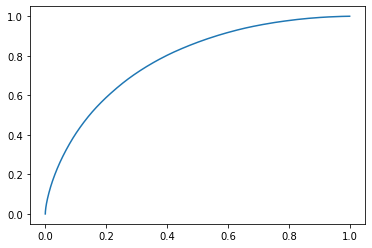

In [36]:
variable = "market_income"
nb_persons = survey_scenario.calculate_variable(
    "number_of_people_per_household", period=year
)
weights = (
    survey_scenario.calculate_variable("household_weight", period=year) * nb_persons
)

y, x = lorenz(
    survey_scenario.calculate_variable(variable, period=year) / nb_persons,
    weights=weights,
)
plt.plot(x, y)

In [37]:
survey_scenario.compute_aggregate("direct_transfers", period=year) / 1e9

23.617592066947427

In [38]:
ceq_variables

['agricultural_inputs_subsidies',
 'alimony',
 'all_income_excluding_transfers',
 'autoconsumption',
 'consumable_income',
 'contributions_health',
 'contributions_pensions',
 'corporate_income_tax',
 'customs_duties',
 'decile_consumable_income_per_capita',
 'decile_disposable_income_per_capita',
 'decile_final_income_per_capita',
 'decile_gross_income_per_capita',
 'decile_market_income_per_capita',
 'decile_market_income_plus_pensions_per_capita',
 'decile_survey_income_per_capita',
 'direct_taxes',
 'disposable_income',
 'electricity_subsidies',
 'employee_contributions_health',
 'employee_contributions_pensions',
 'employee_other_contributions',
 'employer_contributions_health',
 'employer_contributions_pensions',
 'employer_other_contributions',
 'excise_taxes',
 'final_income',
 'food_subsidies',
 'fuel_subsidies',
 'gifts_sales_durables',
 'gross_income',
 'imputed_rent',
 'indirect_subsidies',
 'indirect_taxes',
 'market_income',
 'market_income_plus_pensions',
 'net_market_in

In [39]:
survey_scenario.compute_aggregate("customs_duties", period=year)

72801363171.01367

In [40]:
inflated_survey_scenario = build_ceq_survey_scenario(
    legislation_country=country, year=year, inflate=True
)

In [41]:
sorted(
    [
        variable
        for variable in survey_scenario.tax_benefit_system.variables
        if variable.startswith("poste_")
    ]
)

['poste_10_1_1_1',
 'poste_11_1_1_1_1',
 'poste_12_1_3_item_1',
 'poste_12_1_3_item_2',
 'poste_12_3_1_1',
 'poste_12_7_1_2_1',
 'poste_12_7_1_item_1',
 'poste_12_7_1_item_2',
 'poste_1_1_1_1_1_item_1',
 'poste_1_1_1_1_1_item_2',
 'poste_1_1_1_4_1_item_1',
 'poste_1_1_1_4_1_item_2',
 'poste_1_1_1_4_1_item_3',
 'poste_1_1_1_4_1_item_4',
 'poste_1_1_1_4_1_item_5',
 'poste_1_1_1_4_1_item_6',
 'poste_1_1_1_4_1_item_7',
 'poste_1_1_1_4_3_item_1',
 'poste_1_1_1_4_3_item_2',
 'poste_1_1_1_4_3_item_3',
 'poste_1_1_2_item_1',
 'poste_1_1_2_item_2',
 'poste_1_1_2_item_3',
 'poste_1_1_2_item_4',
 'poste_1_1_2_item_5',
 'poste_1_1_2_item_6',
 'poste_1_1_3_item_1',
 'poste_1_1_3_item_2',
 'poste_1_1_3_item_3',
 'poste_1_1_4_item_1',
 'poste_1_1_4_item_2',
 'poste_1_1_4_item_3',
 'poste_1_1_4_item_4',
 'poste_1_1_5_item_1',
 'poste_1_1_5_item_2',
 'poste_1_1_5_item_3',
 'poste_1_1_5_item_4',
 'poste_1_1_6',
 'poste_1_1_7_item_1',
 'poste_1_1_7_item_2',
 'poste_1_1_7_item_3',
 'poste_1_1_7_item_4',
 

In [42]:
survey_scenario.compute_aggregate("indirect_taxes", period=year)

414988336857.4343

Direct taxes